<a href="https://colab.research.google.com/github/royleekiat/hdbpricer/blob/main/hdbpricer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HDB Resale Price Prediction

Some inspiration (and code) taken from US Housing data prediction https://towardsdatascience.com/house-prices-prediction-using-deep-learning-dea265cc3154

**Dataset for HDB Resale prices**
https://data.gov.sg/dataset/resale-flat-prices

In [1]:
%pip -q install tf-nightly

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import math
import tensorflow as tf
from collections import defaultdict
import numpy as np
from numpy import unique
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, TensorBoard

In [3]:
tf.__version__

'2.4.0-dev20201007'

In [4]:
#Dataset from https://data.gov.sg/dataset/resale-flat-prices
file_url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vQ8OfO82KXoRmO0E6c58MdwsOSc8ns5Geme87SiaiqTUrS_hI8u8mYE5KIOfQe4m2m3GGf9En22xuXx/pub?gid=382289391&single=true&output=csv"
data = pd.read_csv(file_url)



In [5]:
dataframe = data.copy()
dataframe.shape

(77895, 11)

In [6]:
dataframe.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0


We can also use Google Geocode rest API to enrich the dataframe with longtitude and latitude data. For example,
import requests

response = requests.get('https://maps.googleapis.com/maps/api/geocode/json?address=1600+Amphitheatre+Parkway,+Mountain+View,+CA')

resp_json_payload = response.json()

print(resp_json_payload['results'][0]['geometry']['location'])

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local

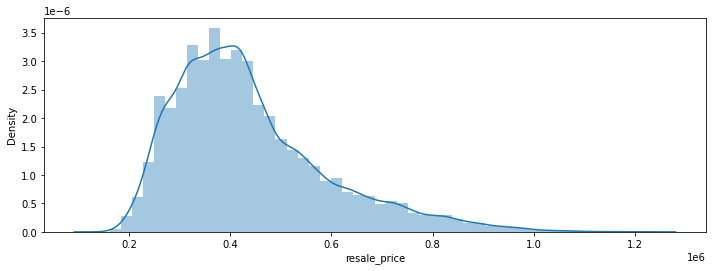

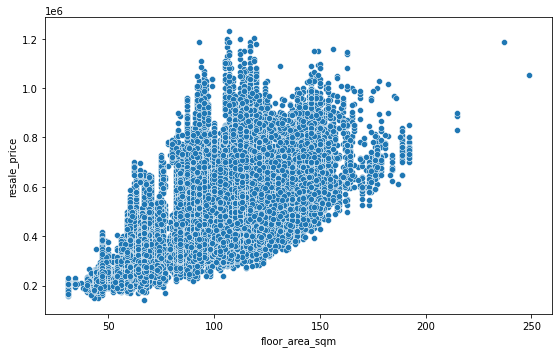

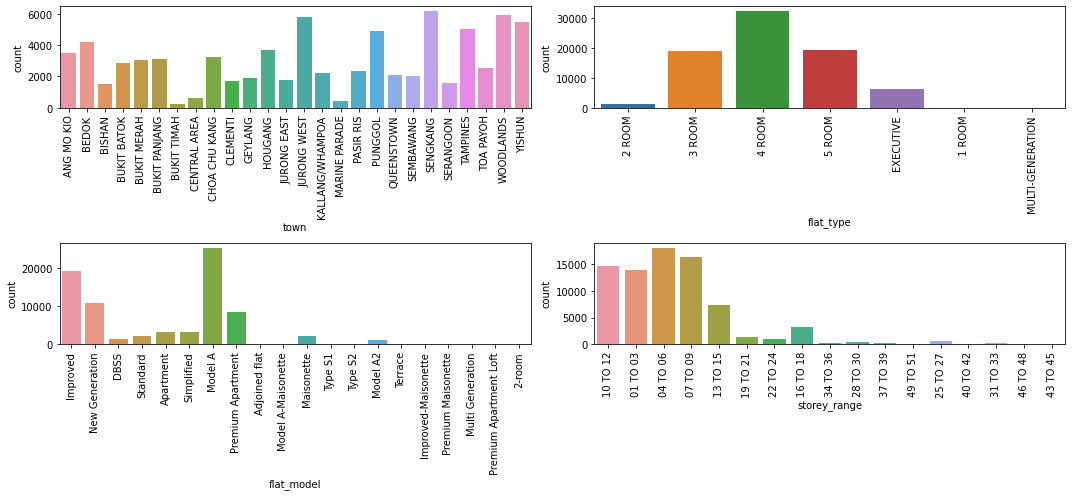

In [7]:
#visualizing house prices
fig = plt.figure(figsize=(10,7))
fig.add_subplot(2,1,1)
sns.distplot(dataframe['resale_price'])
plt.tight_layout()

#visualizing square metres
fig = plt.figure(figsize=(20,12))
fig.add_subplot(2,2,1)
sns.scatterplot(dataframe['floor_area_sqm'], dataframe['resale_price'])


#visualizing bedrooms,bathrooms,floors,grade
fig = plt.figure(figsize=(15,7))
fig.add_subplot(2,2,1)
sns.countplot(dataframe['town'])
plt.xticks(rotation=90)
fig.add_subplot(2,2,2)
sns.countplot(dataframe['flat_type'])
plt.xticks(rotation=90)
fig.add_subplot(2,2,3)
sns.countplot(dataframe['flat_model'])
plt.xticks(rotation=90)
fig.add_subplot(2,2,4)
sns.countplot(dataframe['storey_range'])
plt.xticks(rotation=90)

plt.tight_layout()


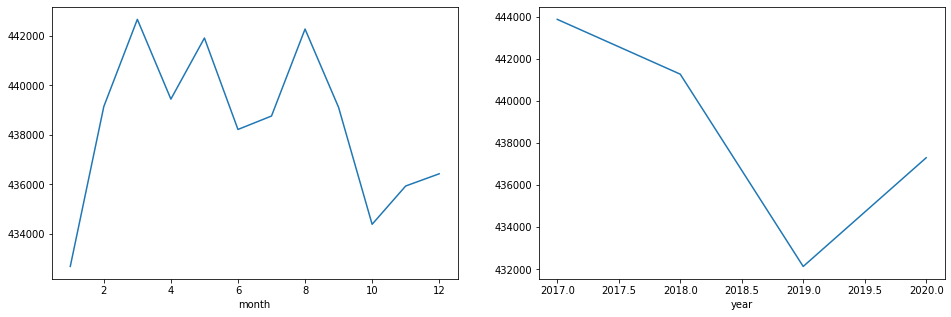

In [8]:
#let's break date to years, months
dataframe['date'] = pd.to_datetime(dataframe['month'])
dataframe['month'] = dataframe['date'].apply(lambda date:date.month)
dataframe['year'] = dataframe['date'].apply(lambda date:date.year)

#Get number of years left on lease as a continuous number (ignoring months)
dataframe['remaining_lease'] = dataframe['remaining_lease'].apply(lambda remaining_lease:remaining_lease[:2])


#data visualization house price vs months and years
fig = plt.figure(figsize=(16,5))
fig.add_subplot(1,2,1)
dataframe.groupby('month').mean()['resale_price'].plot()
fig.add_subplot(1,2,2)
dataframe.groupby('year').mean()['resale_price'].plot()


In [9]:
dataframe.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,date,year
0,1,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61,232000.0,2017-01-01,2017
1,1,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60,250000.0,2017-01-01,2017
2,1,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62,262000.0,2017-01-01,2017
3,1,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62,265000.0,2017-01-01,2017
4,1,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62,265000.0,2017-01-01,2017


In [10]:
# check if there are any Null values
#dataframe.isnull().sum()

# drop some unnecessary columns
dataframe = dataframe.drop('date',axis=1)
'''
dataframe = dataframe.drop('block',axis=1)
dataframe = dataframe.drop('lease_commence_date',axis=1)
dataframe = dataframe.drop('month',axis=1)
dataframe = dataframe.drop('street_name',axis=1)
dataframe = dataframe.drop('flat_model',axis=1)
'''







"\ndataframe = dataframe.drop('block',axis=1)\ndataframe = dataframe.drop('lease_commence_date',axis=1)\ndataframe = dataframe.drop('month',axis=1)\ndataframe = dataframe.drop('street_name',axis=1)\ndataframe = dataframe.drop('flat_model',axis=1)\n"

# Data Split

In [11]:
#X = dataframe.drop('resale_price',axis =1).values
#y = dataframe['resale_price'].values

X = dataframe.drop('resale_price',axis =1)
y = dataframe['resale_price']



In [12]:
### label encode the categorical values and convert them to numbers 
le = LabelEncoder()

X['town']= le.fit_transform(X['town'].astype(str))

X['flat_type'] = le.fit_transform(X['flat_type'].astype(str))

X['street_name'] = le.fit_transform(X['street_name'].astype(str))

X['storey_range'] = le.fit_transform(X['storey_range'].astype(str))

X['flat_model'] = le.fit_transform(X['flat_model'].astype(str))

X['block'] = le.fit_transform(X['block'].astype(str))


In [13]:
X=X.values
y=y.values

In [14]:
#splitting Train and Test 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

Model 1

In [15]:
#standardization scaler - fit&transform on train, fit only on test

s_scaler = StandardScaler()
X_train = s_scaler.fit_transform(X_train.astype(np.float))
X_test = s_scaler.transform(X_test.astype(np.float))


In [16]:
# Multiple Liner Regression
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()  
regressor.fit(X_train, y_train)
#evaluate the model (intercept and slope)
print(regressor.intercept_)
print(regressor.coef_)
#predicting the test set result
y_pred = regressor.predict(X_test)
#put results as a DataFrame
coeff_df = pd.DataFrame(regressor.coef_, dataframe.drop('resale_price',axis =1).columns, columns=['Coefficient']) 
coeff_df

438566.8391174016
[ -3200.21013301 -28534.19812663  28096.81317528 -14231.14648161
   7519.07076957  45389.13163437  67119.17464654  -2810.10339416
 114735.00531432 -89262.44659329 -10702.21096438]


,Coefficient
month,-3200.210133
town,-28534.198127
flat_type,28096.813175
block,-14231.146482
street_name,7519.070770
storey_range,45389.131634
floor_area_sqm,67119.174647
flat_model,-2810.103394
lease_commence_date,114735.005314
remaining_lease,-89262.446593


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


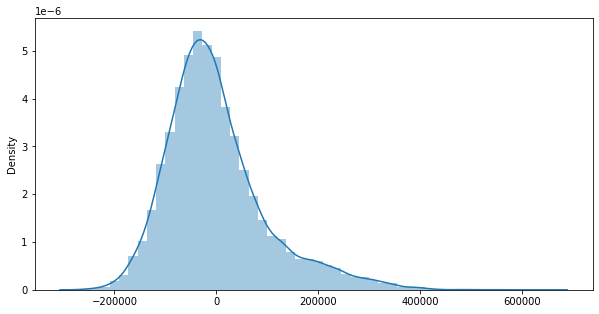

In [17]:
# visualizing residuals
fig = plt.figure(figsize=(10,5))
residuals = (y_test- y_pred)
sns.distplot(residuals)

In [18]:
#compare actual output values with predicted values
y_pred = regressor.predict(X_test)
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1 = df.head(10)
df1


,Actual,Predicted
0,318000.0,422974.048494
1,770000.0,523065.652980
2,851800.0,539307.438685
3,475000.0,527469.397864
4,320000.0,358563.530422
5,305000.0,351953.578110
6,460000.0,506696.465512
7,470000.0,428566.985725
8,468000.0,690691.046654
9,340000.0,521952.539939


In [19]:
print(y_test)

[318000. 770000. 851800. ... 388000. 520000. 465000.]


In [20]:
# evaluate the performance of the algorithm (MAE - MSE - RMSE)
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))  
print('MSE:', metrics.mean_squared_error(y_test, y_pred))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('VarScore:',metrics.explained_variance_score(y_test,y_pred))

MAE: 74161.70907729944
MSE: 9833647410.134441
RMSE: 99164.74882807117
VarScore: 0.5831967030325731


# Model 2

In [21]:
# Creating a Neural Network Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam

In [22]:
# having 19 neuron is based on the number of available features
model = Sequential()
model.add(Dense(19,activation='relu'))
model.add(Dense(19,activation='relu'))
model.add(Dense(19,activation='relu'))
model.add(Dense(19,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='Adam',loss='mse')

In [23]:
model.fit(x=X_train,y=y_train,
          validation_data=(X_test,y_test),
          batch_size=128,epochs=400)
model.summary()

Epoch 1/400
487/487 [==============================] - 1s 2ms/step - loss: 211930233268.4590 - val_loss: 96763641856.0000
Epoch 2/400
487/487 [==============================] - 1s 1ms/step - loss: 48590050774.0328 - val_loss: 15769987072.0000
Epoch 3/400
487/487 [==============================] - 1s 1ms/step - loss: 14959421299.4098 - val_loss: 12168677376.0000
Epoch 4/400
487/487 [==============================] - 1s 1ms/step - loss: 11587349084.3279 - val_loss: 10710591488.0000
Epoch 5/400
487/487 [==============================] - 1s 1ms/step - loss: 10653468871.3443 - val_loss: 9999424512.0000
Epoch 6/400
487/487 [==============================] - 1s 1ms/step - loss: 9869440392.3934 - val_loss: 9575003136.0000
Epoch 7/400
487/487 [==============================] - 1s 1ms/step - loss: 9603399476.4590 - val_loss: 9277521920.0000
Epoch 8/400
487/487 [==============================] - 1s 1ms/step - loss: 9367574435.6721 - val_loss: 9060956160.0000
Epoch 9/400
487/487 [=================

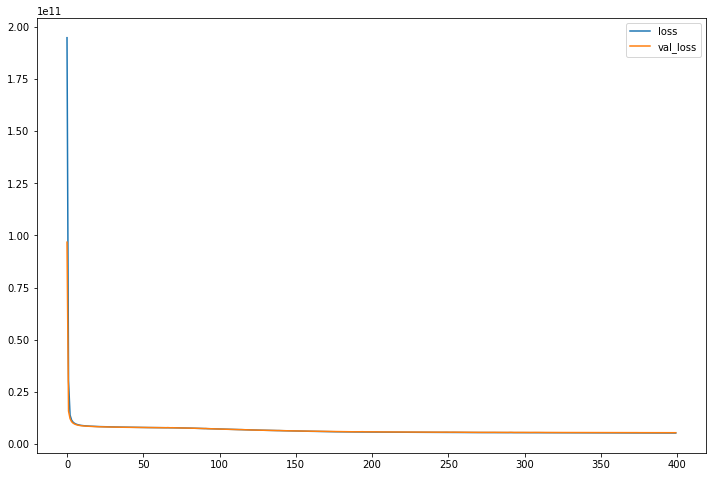

In [24]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot(figsize=(12,8))

MAE: 51890.74289590555
MSE: 5418301376.866801
RMSE: 73609.11205052538
VarScore: 0.770602610165677


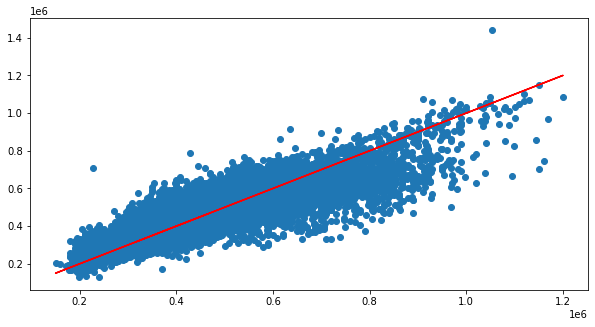

In [25]:
y_pred = model.predict(X_test)
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))  
print('MSE:', metrics.mean_squared_error(y_test, y_pred))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('VarScore:',metrics.explained_variance_score(y_test,y_pred))
# Visualizing Our predictions
fig = plt.figure(figsize=(10,5))
plt.scatter(y_test,y_pred)
# Perfect predictions
plt.plot(y_test,y_test,'r')

In [26]:
# visualizing residuals
'''
fig = plt.figure(figsize=(10,5))
residuals = (y_test- y_pred)
sns.distplot(residuals)
'''

'\nfig = plt.figure(figsize=(10,5))\nresiduals = (y_test- y_pred)\nsns.distplot(residuals)\n'

In [27]:
print(y_pred)

[[344643.34]
 [569016.1 ]
 [643836.  ]
 ...
 [431024.5 ]
 [490247.  ]
 [396152.2 ]]


In [28]:
y_pred_2 = []
for pred in y_pred:
  y_pred_2.append(pred[0])

df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_2})
df1 = df.head(20)
df1

,Actual,Predicted
0,318000.0,344643.34375
1,770000.0,569016.12500
2,851800.0,643836.00000
3,475000.0,465973.12500
4,320000.0,340859.37500
5,305000.0,322941.75000
6,460000.0,423540.68750
7,470000.0,451387.15625
8,468000.0,576561.50000
9,340000.0,437295.31250


# Conclusion

The variance for Keras (Model 2) is better than that of the first model, hence might need some re-engineering to improve this. 